<a href="https://colab.research.google.com/github/chunxu8894/tensorflow-tutorials/blob/master/Save_and_load___Tensorflow_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Save and load models
Model progress can be saved during and after training. This mean a model can resume where it left off and avoid long training times. Saving also mean you can share your model and others can recreate your work. When publishing research models and techniques, most machine learning practitioners share:
- code to create the model
- the trained weights or parameters for the model

### Options
There are different ways to save Tensorflow models - depending on the API you're using. This guide uses tf.keras, a high-level API to build and train models in Tensorflow. For the other approaches, see the Tensorflow [Save and restore](https://www.tensorflow.org/guide/saved_model) guide or [Saving in eager](https://www.tensorflow.org/guide/eager#object-based_saving)

## 1.Install and imports

In [0]:
pip install -q pyyaml h5py

In [2]:
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

2.2.0


## 2. Get an example Dataset


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels= train_labels[:1000]
test_labels = test_labels[:1000]



In [4]:
train_images[1]


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [0]:
fig = plt.figure

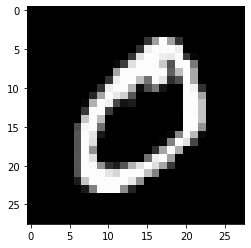

In [6]:
plt.imshow(train_images[1], cmap='gray')
plt.show()

In [0]:
train_images = train_images[:1000].reshape(-1, 28*28) / 255.0
test_images = test_images[:1000].reshape(-1, 28*28) / 255.0

In [8]:
train_images[1].shape

(784,)

## 3. Define a model


In [0]:
def create_model():
  model = tf.keras.models.Sequential([
      keras.layers.Dense(512, activation='relu', input_shape = (784,)),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam', loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## 4. Save checkpoints during training

### Checkpoint callback usage

In [11]:
checkpoint_path = "training_1/cp.ckpt"
checkpoing_dir = os.path.dirname(checkpoint_path)

#Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

#Train the model with new callback
model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), callbacks=[cp_callback])


Epoch 1/10
29/32 [==========================>...] - ETA: 0s - loss: 1.2147 - accuracy: 0.6627
Epoch 00001: saving model to training_1/cp.ckpt
32/32 [==============================] - 0s 14ms/step - loss: 1.1734 - accuracy: 0.6760 - val_loss: 0.7041 - val_accuracy: 0.7830
Epoch 2/10
29/32 [==========================>...] - ETA: 0s - loss: 0.4171 - accuracy: 0.8804
Epoch 00002: saving model to training_1/cp.ckpt
32/32 [==============================] - 0s 7ms/step - loss: 0.4143 - accuracy: 0.8820 - val_loss: 0.5346 - val_accuracy: 0.8430
Epoch 3/10
29/32 [==========================>...] - ETA: 0s - loss: 0.2866 - accuracy: 0.9256
Epoch 00003: saving model to training_1/cp.ckpt
32/32 [==============================] - 0s 7ms/step - loss: 0.2864 - accuracy: 0.9260 - val_loss: 0.4577 - val_accuracy: 0.8560
Epoch 4/10
28/32 [=========================>....] - ETA: 0s - loss: 0.1959 - accuracy: 0.9531
Epoch 00004: saving model to training_1/cp.ckpt
32/32 [==============================] - 0s 

In [12]:
ls {checkpoing_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


Create a new, untrained model. When restoring a model from weights-only, you must have a model with the same architecture as the original model. Since it's the same model architecture, you can share weights despite that it's a different instance of the model

Now rebuild a fresh, untrained model and evaluate it on the test set. An untrained model will perform at chance levels (~10% accuracy)

In [13]:
#Create a basic instance
model = create_model()
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

32/32 - 0s - loss: 2.2818 - accuracy: 0.1590
Untrained model, accuracy: 15.90%


In [14]:
model.load_weights(checkpoint_path)
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

32/32 - 0s - loss: 0.4175 - accuracy: 0.8620


### Checkpoint callback options
the callback provide several options to provide unique names for checkpoints and adjust the checkpointing frequency

Train a new model, and save uniquely name checkpoints once every five epochs

In [15]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoing_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose = 1, save_weights_only = True, period = 5
)

model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))
model.fit(train_images, train_labels,epochs=50, callbacks=[cp_callback], validation_data=(test_images, test_labels), verbose=0)


Epoch 00005: saving model to training_2/cp-0005.ckpt

Epoch 00010: saving model to training_2/cp-0010.ckpt

Epoch 00015: saving model to training_2/cp-0015.ckpt

Epoch 00020: saving model to training_2/cp-0020.ckpt

Epoch 00025: saving model to training_2/cp-0025.ckpt

Epoch 00030: saving model to training_2/cp-0030.ckpt

Epoch 00035: saving model to training_2/cp-0035.ckpt

Epoch 00040: saving model to training_2/cp-0040.ckpt

Epoch 00045: saving model to training_2/cp-0045.ckpt

Epoch 00050: saving model to training_2/cp-0050.ckpt


In [17]:
%ls {checkpoing_dir}

checkpoint                        cp-0025.ckpt.data-00000-of-00001
cp-0000/                          cp-0025.ckpt.index
cp-0000.ckpt.data-00000-of-00001  cp-0026/
cp-0000.ckpt.index                cp-0027/
cp-0001/                          cp-0028/
cp-0002/                          cp-0029/
cp-0003/                          cp-0030/
cp-0004/                          cp-0030.ckpt.data-00000-of-00001
cp-0005/                          cp-0030.ckpt.index
cp-0005.ckpt.data-00000-of-00001  cp-0031/
cp-0005.ckpt.index                cp-0032/
cp-0006/                          cp-0033/
cp-0007/                          cp-0034/
cp-0008/                          cp-0035/
cp-0009/                          cp-0035.ckpt.data-00000-of-00001
cp-0010/                          cp-0035.ckpt.index
cp-0010.ckpt.data-00000-of-00001  cp-0036/
cp-0010.ckpt.index                cp-0037/
cp-0011/                          cp-0038/
cp-0012/                          cp-0039/
cp-0013/                          cp-0

In [0]:
latest = tf.train.latest_checkpoint(checkpoing_dir)

In [19]:
latest

'training_2/cp-0050.ckpt'

In [20]:
model = create_model()
model.load_weights(latest)
loss, acc = model.evaluate(test_images, test_labels, verbose=1)

32/32 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.8790


## Checkpoints contain:
- One or more shards that contain your model weights
- An index file that indicates which weights are stored in a which shard

## 5. Manually save weights
Manually saving the weights into a model is just as simple with the Model.save_weights method
By default, tf.keras and save_weights in particular uses the Tensorflow checkpoint format with a .ckpt extension (saving in HDF5 with .h5 extension is covered in the [Save and serialize models guide](https://www.tensorflow.org/guide/keras/save_and_serialize#weights_only_saving_in_savedmodel_format)

In [15]:
#save the weights
model.save_weights('./checkpoints/my_checkpoint')

#Create a new model instance
model = create_model()

#Restore the weights
model.load_weights('./checkpoints/my_checkpoint')

## 6. Save the entire model

Call model.save to save a model's architecture, weights, and training configuration in a single file/folder.

Entire model can be saved in two different file formats (SavedModel and HDF5). It is to be noted that Tensorflow SavedModel format is the default file format in TF2.x. However, model can be saved in HDF5 format. Saving a fully- functional model is very usefull- you can load them in Tensorflow.js (SavedModel, HDF5) and then train and run them in web browsers or convert them to run on mobile devices using Tensorflow Lite(SavedModel, HDF5)

### SavedModel format

the SavedModel format is another way to serialize models. Models saved in this format can be restored using tf.keras.models.load_model and ar compatible with Tensorflow Serving. The SavedModel guide goes into detail about how to serve/inspect the SavedModel.

In [21]:
model = create_model()
model.fit(train_images, train_labels, epochs= 5)

Epoch 1/5
32/32 [==============================] - 0s 4ms/step - loss: 1.1819 - accuracy: 0.6530
Epoch 2/5
32/32 [==============================] - 0s 4ms/step - loss: 0.4442 - accuracy: 0.8760
Epoch 3/5
32/32 [==============================] - 0s 4ms/step - loss: 0.2981 - accuracy: 0.9250
Epoch 4/5
32/32 [==============================] - 0s 4ms/step - loss: 0.2174 - accuracy: 0.9430
Epoch 5/5
32/32 [==============================] - 0s 4ms/step - loss: 0.1479 - accuracy: 0.9700


In [23]:
!mkdir -p saved_model
model.save('saved_model/my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [25]:
!ls saved_model/my_model

assets	saved_model.pb	variables


Reload a fresh Keras model from the saved model:

In [27]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [28]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose= 2)

32/32 - 0s - loss: 0.4102 - accuracy: 0.8740


### HDF5 format
Keras provide a basic save format using the HDF5 standard

In [30]:
#Create and train a new model instance
model = create_model()
model.fit(train_images, train_labels, epochs=5)
model.save('my_model.h5')

Epoch 1/5
32/32 [==============================] - 0s 4ms/step - loss: 1.1645 - accuracy: 0.6940
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 0.4306 - accuracy: 0.8710
Epoch 3/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.9300
Epoch 4/5
32/32 [==============================] - 0s 3ms/step - loss: 0.2110 - accuracy: 0.9480
Epoch 5/5
32/32 [==============================] - 0s 4ms/step - loss: 0.1525 - accuracy: 0.9680


In [31]:
new_model = tf.keras.models.load_model('my_model.h5')
new_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [32]:
loss, acc = new_model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))


32/32 - 0s - loss: 0.4564 - accuracy: 0.8440
Restored model, accuracy: 84.40%


Keras saves models by inspecting the architecture. This technique saves everything:
- The weight values
- The model's architecture
- The model's training configuration (what you passed to compile)
- The optimizer and its state, if any (this enables you to restart training where you left)

Keras is not able to save v1.x optimizers (from tf.compat.v1.train) since they aren't compatible with checkpoints. For v1.x optimizers, you need to recompile the model after loading-losing the state of the optimizer



### Saving custom objects
If you are using the SavedModel format, you can skip this section. The key difference between HDF5 and SavedModel is that HDF5 uses object configs to save the model architecture, while SavedModel saves the execution graph. Thus, SavedModel are able to save custom object like subclassed models and custom layers without requiring the original code.



#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
